In [1]:
#Install what is needed
!pip install pandas numpy matplotlib xarray hvplot
!pip install rasterio
!pip install rioxarray
!pip install fiona 
!pip install geopandas
!pip install cartopy
!pip install geopandas geoviews
!pip install netCDF4
!pip install pydap
!pip install pygbif
!pip install osmnx
!pip install earthaccess


#Import from installations
import fiona
import os
import pathlib
import hvplot.xarray  
import rioxarray  
import pathlib
import requests
import zipfile
import geopandas as gpd 
import hvplot.pandas
import netCDF4
import earthaccess


import xarray as xr
import geopandas as gpd
import rioxarray as rxr
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrsp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import floor, ceil
from shapely.geometry import box
from rioxarray.merge import merge_arrays
from osmnx import features as osm
from pygbif import occurrences
from glob import glob
from rioxarray.merge import merge_arrays
from shapely.geometry import Point

In [2]:
# save records into the iplant user
iplant_user = os.environ['IPLANT_USER']
data_path = (
    pathlib.Path.home()
    / 'data-store' / 'home' / iplant_user / 'habitat_suitability')

data_path.mkdir(parents = True, exist_ok = True)

data_path

# Define and create the project data directory
habitat_suitability_data_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data',
    'habitat_suitability'
)
os.makedirs(habitat_suitability_data_dir, exist_ok=True)

# Call the data directory to check its location
habitat_suitability_data_dir


# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Define correct project directory path
project_data_dir = os.path.join(
    pathlib.Path.home(),
    'Rocky_Mountain_Juniper_Study',
    'data',
    'habitat_suitability'
)
os.makedirs(project_data_dir, exist_ok=True)

print("Data directory is:", project_data_dir)

# Define WKT bounding box for ROMO area
bbox = "POLYGON((-105.9 40.1, -105.4 40.1, -105.4 40.6, -105.9 40.6, -105.9 40.1))"

# Query GBIF for Juniperus scopulorum
records = occurrences.search(
    scientificName="Juniperus scopulorum",
    hasCoordinate=True,
    limit=1000,
    geometry=bbox
)

# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Search Juniperus scopulorum within bounding box (ROMO)
forest_gdf = osm.features_from_place(
    query = 'Roosevelt National Forest',
    tags = {'name':'Roosevelt National Forest'})

# ---------------------------------------------------------------------------------------------------------------------------------------------------
forest_gdf = forest_gdf.iloc[[0]]

# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Convert GBIF records (list of dicts) to DataFrame
juniper_gdf = gpd.read_file ('Juniper_Occur.zip')

juniper_gdf.eventDate = pd.to_datetime(juniper_gdf.eventDate , format='ISO8601', utc=True)

# Drop rows without lat/lon
juniper_gdf = juniper_gdf.dropna(subset=["decimalLatitude", "decimalLongitude","eventDate"])

juniper_gdf = (
    gpd.GeoDataFrame(
        juniper_gdf, 
        geometry=gpd.points_from_xy(
            juniper_gdf.decimalLongitude, 
            juniper_gdf.decimalLatitude), 
        crs="EPSG:4326")
    # Select the desired columns
    [['eventDate','geometry']]
)

# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Ensure both are in EPSG:4326 for web maps
forest_gdf = forest_gdf.to_crs("EPSG:4326")
juniper_gdf = juniper_gdf.to_crs("EPSG:4326")

juniper_occur_gdf = juniper_gdf.sjoin(
    gpd.GeoDataFrame(
        geometry = forest_gdf.envelope),
    predicate = 'within')

Data directory is: /home/jovyan/Rocky_Mountain_Juniper_Study/data/habitat_suitability


In [3]:
# Prep for downloading SRTM 

# Define and create the project data directory
habitat_suitability_data_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data',
    'habitat_suitability'
)
os.makedirs(habitat_suitability_data_dir, exist_ok=True)

# Call the data directory to check its location
habitat_suitability_data_dir

# Create data dir 
elevation_dir= os.path.join(habitat_suitability_data_dir, 'srtm')
os.makedirs(elevation_dir, exist_ok=True)

# call the variable to check location
elevation_dir

'/home/jovyan/earth-analytics/data/habitat_suitability/srtm'

In [4]:
# Download Raster data through earthaccess Part 1 of 1
# Login and search earthaccess, download results

# login to earthaccess
earthaccess.login(strategy="interactive", persist=True)

bounds = tuple(forest_gdf.total_bounds)

# Search earthaccess
elevation_results = earthaccess.search_data(
    short_name = "SRTMGL1",
    bounding_box = bounds
)
elevation_results

# Download earthaccess results
srtm_files = earthaccess.download(elevation_results, elevation_dir)

# Return a list of file paths that match the pattern
srtm_files = glob (os.path.join(
    elevation_dir, 
    '*hgt.zip')
)

# Call srtm_file to see it 
srtm_files

INFO:You're now authenticated with NASA Earthdata Login
INFO:Granules found: 4
INFO: Getting 4 granules, approx download size: 0.05 GB


QUEUEING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

INFO:File N39W106.SRTMGL1.hgt.zip already downloaded
INFO:File N39W107.SRTMGL1.hgt.zip already downloaded


PROCESSING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

INFO:File N40W107.SRTMGL1.hgt.zip already downloaded
INFO:File N40W106.SRTMGL1.hgt.zip already downloaded


COLLECTING RESULTS | :   0%|          | 0/4 [00:00<?, ?it/s]

['/home/jovyan/earth-analytics/data/habitat_suitability/srtm/N39W106.SRTMGL1.hgt.zip',
 '/home/jovyan/earth-analytics/data/habitat_suitability/srtm/N39W107.SRTMGL1.hgt.zip',
 '/home/jovyan/earth-analytics/data/habitat_suitability/srtm/N40W106.SRTMGL1.hgt.zip',
 '/home/jovyan/earth-analytics/data/habitat_suitability/srtm/N40W107.SRTMGL1.hgt.zip']

In [5]:
# Create list of files for each study area
juniper_srtm_files = list(srtm_files)

# Call list to make sure it's right
juniper_srtm_files

['/home/jovyan/earth-analytics/data/habitat_suitability/srtm/N39W106.SRTMGL1.hgt.zip',
 '/home/jovyan/earth-analytics/data/habitat_suitability/srtm/N39W107.SRTMGL1.hgt.zip',
 '/home/jovyan/earth-analytics/data/habitat_suitability/srtm/N40W106.SRTMGL1.hgt.zip',
 '/home/jovyan/earth-analytics/data/habitat_suitability/srtm/N40W107.SRTMGL1.hgt.zip']

In [6]:
# Create function with description to process srtm raster images
# Part 1 of 1
def process_image_list(url_list, chosen_buffer, bounds_gdf):
    """
    Load, crop, and scale a raster image 

    Parameters
    ----------
    url: file-like or path-like
      File accessor downloaded or obtained 
    chosen_buffer: float number
      Amount of degrees to extend past the bounds of the bounds_gdf 
    bounds_gdf: gpd.GeoDataFrame
      Area of interest to crop to

    Returns
    -------
    merged_da: rxr.DataArray
      Processed raster
    """   
        
    # List to store cropped DataArrays for the current site 
    da_list= []
      
    buffer= chosen_buffer

    for url in url_list:

        # Connect to the raster image
        da = rxr.open_rasterio(
          url, 
          mask_and_scale=True
          ).squeeze()
        
          # Get the study bounds
        bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat = (
          bounds_gdf
          .to_crs(da.rio.crs)
          .total_bounds 
          )
# Crop the raster image to the bounds of the study area
        cropped_da = (
          da.rio.clip_box(bounds_min_lon-buffer, bounds_min_lat-buffer, bounds_max_lon+buffer, bounds_max_lat+buffer)
          )
        
        # Append the cropped DataArray to the list
        da_list.append(cropped_da)

    # Merge the cropped DataArrays for this site
    merged_da = (
      merge_arrays(da_list)
      )
        
    return merged_da

In [7]:
# Use process_image_list function on each set of site files 
# save to new variable names to use later

# Use process_image_list function on comanche srtm files
srtm_juniper_result_da = process_image_list(juniper_srtm_files, .025, forest_gdf)


# Create a list to save the site srtm results to
srtm_da_results = [
    srtm_juniper_result_da,
]
srtm_da_results

print("Raster CRS:", srtm_juniper_result_da.rio.crs)
print("GDF CRS:", juniper_occur_gdf.crs)

juniper_occur_gdf = juniper_occur_gdf[juniper_occur_gdf.geometry.notnull() & juniper_occur_gdf.is_valid]
forest_gdf = forest_gdf[forest_gdf.geometry.notnull() & forest_gdf.is_valid]

print("Juniper GDF bounds:", juniper_occur_gdf.total_bounds)
print("RMNP GDF bounds:", forest_gdf.total_bounds)
# Reproject vector to match raster
juniper_occur_gdf = juniper_occur_gdf.to_crs(srtm_juniper_result_da.rio.crs)

Raster CRS: EPSG:4326
GDF CRS: EPSG:4326
Juniper GDF bounds: [-106.15445    39.849905 -105.190508   40.89    ]
RMNP GDF bounds: [-106.195438    39.8470609 -105.1901814   40.997754 ]


/tmp/ipykernel_15965/1985416407.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


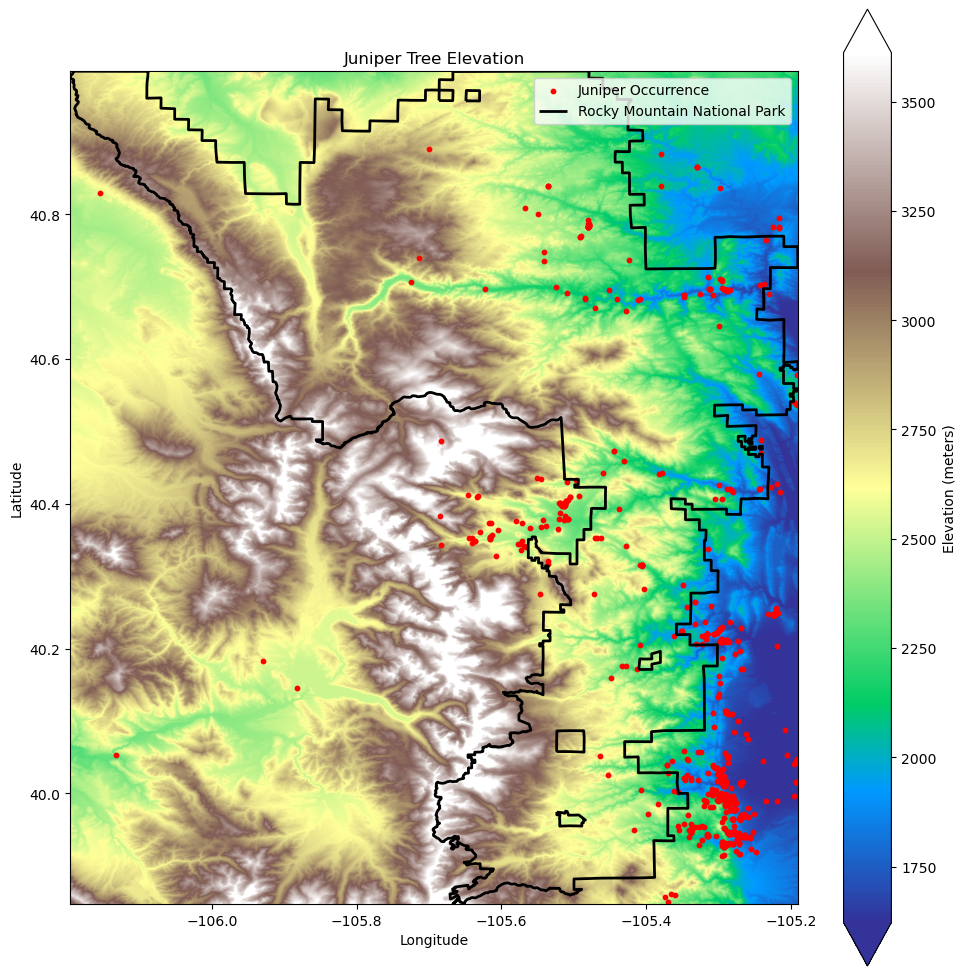

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot raster
srtm_juniper_result_da.plot(
    ax=ax,
    cmap='terrain',
    robust=True,
    cbar_kwargs={"label": "Elevation (meters)"}
)

if juniper_gdf.geometry.iloc[0].geom_type == "Point":
    juniper_gdf.plot(ax=ax, color='red', markersize=10, label='Juniper Occurrence')
else:
    juniper_gdf.boundary.plot(ax=ax, color='red', linewidth=1, label='Juniper Boundary')

# Plot Boulder boundary
forest_gdf.boundary.plot(ax=ax, color='black', linewidth=2, label='Rocky Mountain National Park')

# Set valid aspect ratio
ax.set_aspect('equal')  
b_box = forest_gdf.total_bounds
ax.set_xlim(b_box[0],b_box[2])
ax.set_ylim(b_box[1],b_box[3])


# Label the axes
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Add title, legend, and formatting
ax.set_title("Juniper Tree Elevation")
ax.legend()

plt.tight_layout()
plt.show()